In [31]:
import wandb
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import importlib
from common import common
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.datasets import fetch_covtype

In [21]:
wandb.login()

True

In [41]:
# Reload common module
importlib.reload(common)

<module 'common.common' from '/home/brina/nus-mcomp/sem2/cs5344-big-data-analytics-technology/CS5344_Project.git/sy/work/common/common.py'>

In [33]:
# Function to evaluate and print model performance
def evaluate_model(model, X_train, y_train, X_test, y_test):
    seconds = time.time()
    # Train the model
    model.fit(X_train, y_train)
    print("Train operation time: = ",time.time()- seconds ,"seconds")
    
    # Make predictions on the test set
    y_pred = model.predict(X_test)
    
    # Print model evaluation metrics
    common.evaluate(y_test, y_pred, f"\nModel: {model.__class__.__name__}")

In [23]:
# Dictionary to store models and their names
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=100, random_state=42),
    "K-Nearest Neighbors": KNeighborsClassifier(n_neighbors=5),
    "Support Vector Machine (SVM)": SVC()
}

In [ ]:
# project name should correspond to dataset below
# project_name = "covertype"
# project_name = "kdd"
# project_name = "cicids"
# project_name = "thyroid"
project_name = "unsw"

In [24]:
# %run datasets/covertype.ipynb
# %run datasets/kdd.ipynb
# %run datasets/cicids.ipynb
# %run datasets/thyroid.ipynb
%run datasets/unsw.ipynb

In [25]:
# Should already be one hot encoded and label encoded
# all_df, main_labels, config = get_processed_covtype_df()
# all_df, main_labels, config = get_processed_kdd_df()
# all_df, main_labels, config = get_processed_cicids_df()
# all_df, main_labels, config = get_processed_thyroid_df()
all_df, main_labels, config = get_processed_unsw_df()

TARGET_COLUMN = config['TARGET_COLUMN']
NORMAL_TARGET = config['NORMAL_TARGET']
TARGET_DICT = config['TARGET_DICT']
INV_TARGET_DICT = config['INV_TARGET_DICT']
NUMERICAL_COLUMNS = config['NUMERICAL_COLUMNS']
CATEGORICAL_COLUMNS = config['CATEGORICAL_COLUMNS']
ORDINAL_COLUMNS = config['ORDINAL_COLUMNS']
all_df.head()

Normal class:  0    Normal
Name: attack_cat, dtype: category
Categories (10, object): ['Analysis', 'Backdoor', 'DoS', 'Exploits', ..., 'Normal', 'Reconnaissance', 'Shellcode', 'Worms']
TARGET_DICT {0: 'Analysis', 1: 'Backdoor', 2: 'DoS', 3: 'Exploits', 4: 'Fuzzers', 5: 'Generic', 6: 'Normal', 7: 'Reconnaissance', 8: 'Shellcode', 9: 'Worms'}
NORMAL_TARGET 6
main_labels Index(['dur', 'spkts', 'dpkts', 'sbytes', 'dbytes', 'rate', 'sload', 'dload',
       'sloss', 'dloss',
       ...
       'service_ssl', 'state_CON', 'state_ECO', 'state_FIN', 'state_INT',
       'state_PAR', 'state_REQ', 'state_RST', 'state_URN', 'state_no'],
      dtype='object', length=187)


,dur,spkts,dpkts,sbytes,dbytes,rate,sload,dload,sloss,dloss,...,service_ssl,state_CON,state_ECO,state_FIN,state_INT,state_PAR,state_REQ,state_RST,state_URN,state_no
0,0.121478,6,4,258,172,74.087486,14158.942383,8495.365234,0,0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.649902,14,38,734,42014,78.473373,8395.112305,503571.312500,2,17,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.623129,8,16,364,13186,14.170161,1572.271851,60929.230469,1,6,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.681642,12,12,628,770,13.677108,2740.178955,3358.622070,1,3,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.449454,10,6,534,268,33.373825,8561.499023,3987.059814,2,1,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [26]:
# Get X and y from all_df
X_df = all_df.drop(columns=[TARGET_COLUMN])
y_df = all_df[TARGET_COLUMN]

# Split the data into training and testing sets (80% train, 20% test)
X_train_df, X_test_df, y_train_df, y_test_df = train_test_split(X_df, y_df, test_size=0.2, random_state=42)
print(X_train_df.shape, X_test_df.shape, y_train_df.shape, y_test_df.shape)

(140272, 186) (35069, 186) (140272,) (35069,)


In [27]:
# Fit and transform the numeric columns
scaler, X_train_scaled_df = common.standardise(X_train_df, NUMERICAL_COLUMNS)
# print('X_train_scaled_df', X_train_scaled_df)

# Use the same scaler to transform X_test
scaler, X_test_scaled_df = common.standardise(X_test_df, NUMERICAL_COLUMNS, scaler=scaler)
# print('X_test_scaled_df', X_test_scaled_df)

/home/brina/miniconda3/envs/gpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Train operation time: =  88.1288161277771 seconds

Model: LogisticRegression
Confusion Matrix:
[[  27    0    3  338    0    0   25    0    0    0]
 [   0    1    4  307   16    0   12   20    0    0]
 [   0    0   27 2143   74   16   67   43    0    0]
 [   1    2   72 5693  332   18  389  265    0    0]
 [   0    0    2  436 2334    0  482  316    0    0]
 [   0    0    1  136   32 7886   18    6    0    0]
 [  12    0    4  285 1565    9 9092  202    0    0]
 [   0    0    7  505  203    7   29 1347    0    0]
 [   0    0    0    0  113    0    5  115    0    0]
 [   0    0    0   21    2    0    0    2    0    0]]


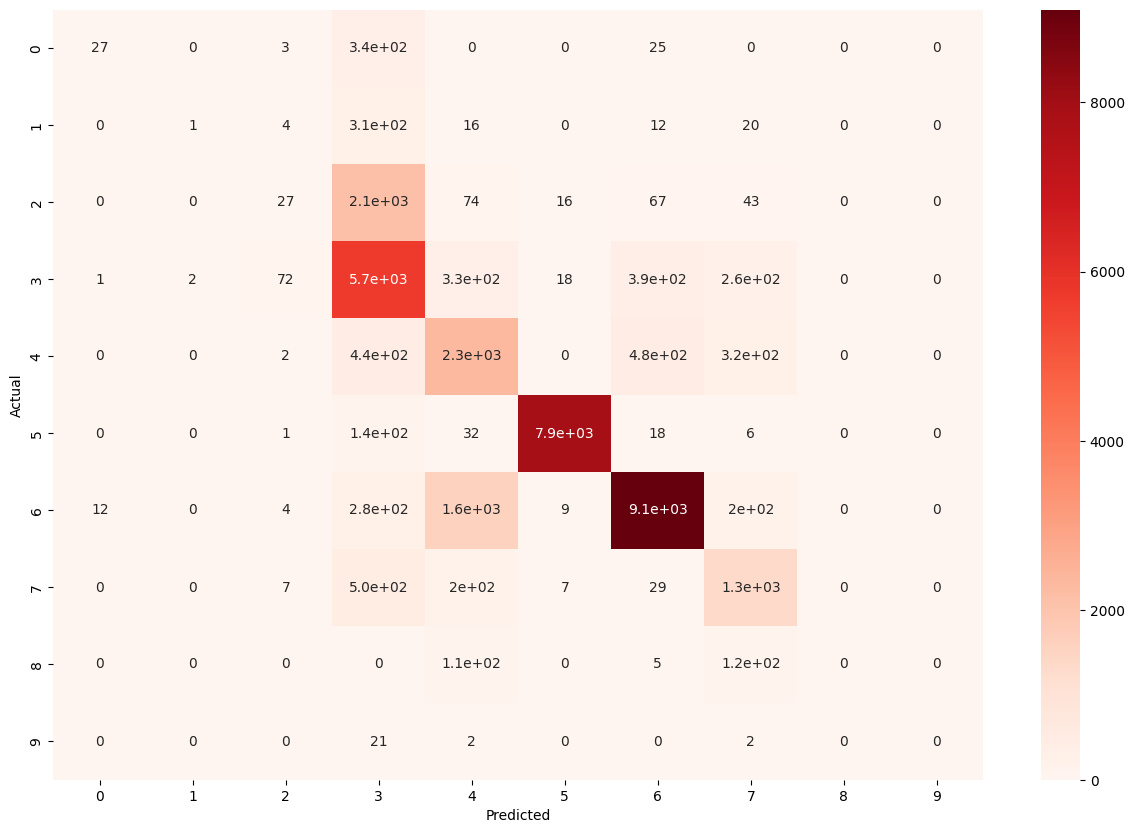

/home/brina/miniconda3/envs/gpu/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/brina/miniconda3/envs/gpu/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/brina/miniconda3/envs/gpu/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Classification Report:
{'0': {'precision': 0.675, 'recall': 0.06870229007633588, 'f1-score': 0.12471131639722864, 'support': 393.0}, '1': {'precision': 0.3333333333333333, 'recall': 0.002777777777777778, 'f1-score': 0.005509641873278238, 'support': 360.0}, '2': {'precision': 0.225, 'recall': 0.01139240506329114, 'f1-score': 0.021686746987951807, 'support': 2370.0}, '3': {'precision': 0.5771492295214923, 'recall': 0.8406674542232723, 'f1-score': 0.6844193315700889, 'support': 6772.0}, '4': {'precision': 0.49967886962106617, 'recall': 0.653781512605042, 'f1-score': 0.5664361121223151, 'support': 3570.0}, '5': {'precision': 0.9936995967741935, 'recall': 0.9761109048149523, 'f1-score': 0.9848267249453637, 'support': 8079.0}, '6': {'precision': 0.8985077576835656, 'recall': 0.8140388575521533, 'f1-score': 0.8541901540774146, 'support': 11169.0}, '7': {'precision': 0.5816062176165803, 'recall': 0.6420400381315539, 'f1-score': 0.6103307657453556, 'support': 2098.0}, '8': {'precision': 0.0, '

Accuracy Score,▁
f1-score_avg,▁
precision_avg,▁
recall_avg,▁
Accuracy Score,0.753
f1-score_avg,0.72819
precision_avg,0.73839
recall_avg,0.753


Train operation time: =  2.8289055824279785 seconds

Model: DecisionTreeClassifier
Confusion Matrix:
[[   67     5    51   235     1     0    34     0     0     0]
 [    2    42    47   258     2     0     3     3     2     1]
 [    2     1   407  1879    21     8    32    14     6     0]
 [    7    16   790  5533    85    35   117   155    23    11]
 [    7     4    73   320  2405     6   718     4    32     1]
 [    0     2    32    95    12  7930     7     0     0     1]
 [   33     4    27   129   808     6 10116    14    32     0]
 [    0     5    81   432     3     1    12  1559     4     1]
 [    0     1    14    31    46     1    29     2   109     0]
 [    0     0     1    14     1     0     0     2     0     7]]


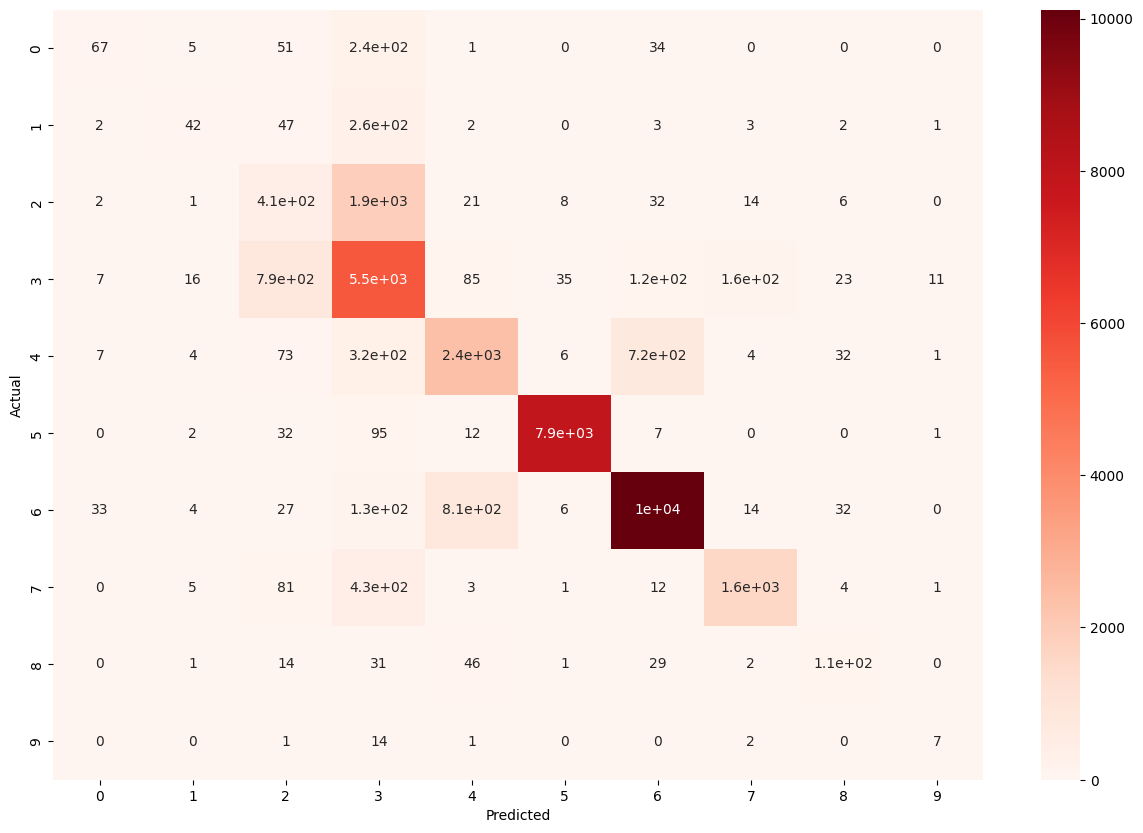


Classification Report:
{'0': {'precision': 0.5677966101694916, 'recall': 0.17048346055979643, 'f1-score': 0.2622309197651663, 'support': 393.0}, '1': {'precision': 0.525, 'recall': 0.11666666666666667, 'f1-score': 0.19090909090909092, 'support': 360.0}, '2': {'precision': 0.26723571897570586, 'recall': 0.17172995780590716, 'f1-score': 0.2090932442846134, 'support': 2370.0}, '3': {'precision': 0.6198745238628726, 'recall': 0.8170407560543415, 'f1-score': 0.7049305644031088, 'support': 6772.0}, '4': {'precision': 0.7106973995271868, 'recall': 0.6736694677871149, 'f1-score': 0.6916882369859074, 'support': 3570.0}, '5': {'precision': 0.9928634030299236, 'recall': 0.9815571234063621, 'f1-score': 0.9871778911988048, 'support': 8079.0}, '6': {'precision': 0.9139862667148536, 'recall': 0.9057211925866236, 'f1-score': 0.909834959751765, 'support': 11169.0}, '7': {'precision': 0.8893325727324587, 'recall': 0.7430886558627264, 'f1-score': 0.8096598286159439, 'support': 2098.0}, '8': {'precision'

Accuracy Score,▁
f1-score_avg,▁
precision_avg,▁
recall_avg,▁
Accuracy Score,0.80342
f1-score_avg,0.79469
precision_avg,0.7986
recall_avg,0.80342


Train operation time: =  23.2949001789093 seconds

Model: RandomForestClassifier
Confusion Matrix:
[[   54     3    42   248     2     0    44     0     0     0]
 [    2    37    42   267     4     0     2     4     2     0]
 [    3     3   314  1971    33     0    23    16     7     0]
 [    3     0   509  5922   101     6    89   126    16     0]
 [    5     3    52   315  2594     6   566     3    26     0]
 [    0     1    23   137    16  7896     4     0     0     2]
 [    4     0     1    96   842     0 10203    15     7     1]
 [    0     2    73   437     3     0     2  1581     0     0]
 [    0     0     6    26    62     2    38     2    97     0]
 [    0     0     0    23     1     0     0     0     0     1]]


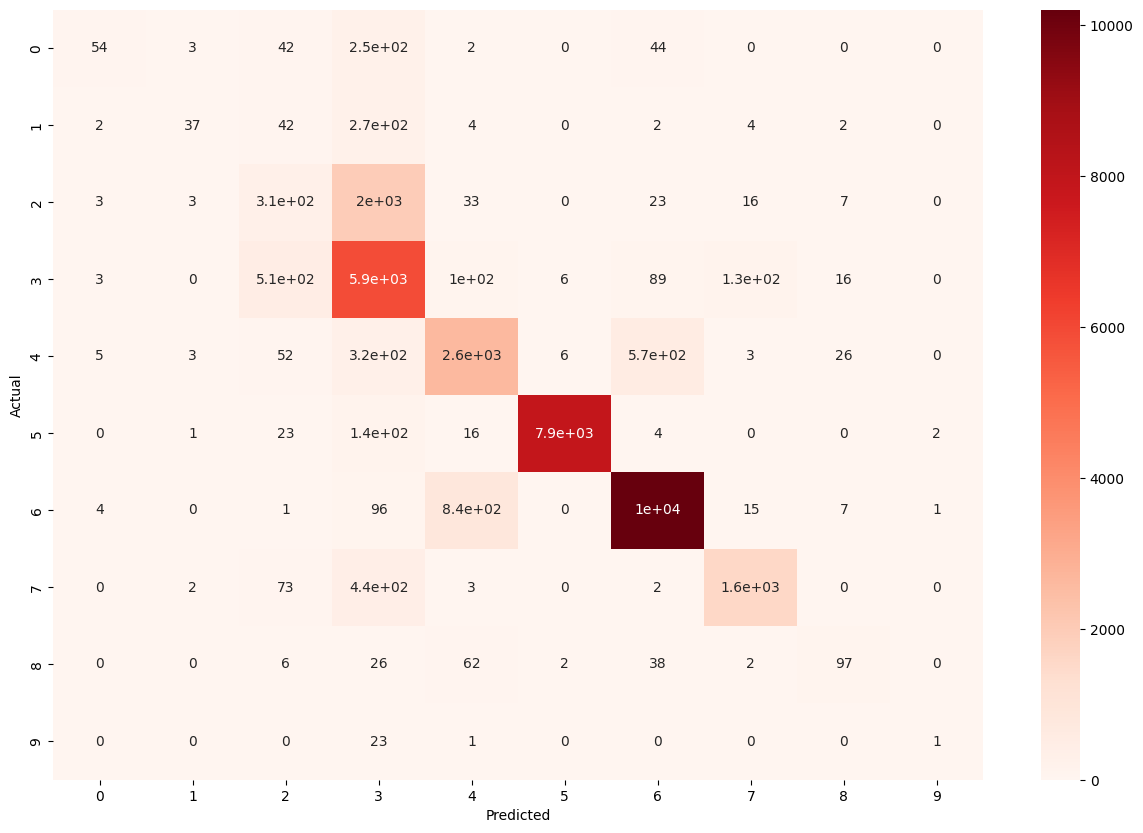


Classification Report:
{'0': {'precision': 0.7605633802816901, 'recall': 0.13740458015267176, 'f1-score': 0.2327586206896552, 'support': 393.0}, '1': {'precision': 0.7551020408163265, 'recall': 0.10277777777777777, 'f1-score': 0.18092909535452323, 'support': 360.0}, '2': {'precision': 0.295668549905838, 'recall': 0.13248945147679325, 'f1-score': 0.18298368298368298, 'support': 2370.0}, '3': {'precision': 0.6271976276212666, 'recall': 0.8744831659775546, 'f1-score': 0.7304798322437399, 'support': 6772.0}, '4': {'precision': 0.7091306724986332, 'recall': 0.726610644257703, 'f1-score': 0.7177642501383508, 'support': 3570.0}, '5': {'precision': 0.9982300884955753, 'recall': 0.9773486817675455, 'f1-score': 0.9876790293326662, 'support': 8079.0}, '6': {'precision': 0.9299972655181843, 'recall': 0.9135106097233414, 'f1-score': 0.9216802168021679, 'support': 11169.0}, '7': {'precision': 0.9049799656554093, 'recall': 0.7535748331744518, 'f1-score': 0.822366710013004, 'support': 2098.0}, '8': {

Accuracy Score,▁
f1-score_avg,▁
precision_avg,▁
recall_avg,▁
Accuracy Score,0.81836
f1-score_avg,0.80461
precision_avg,0.81419
recall_avg,0.81836


Train operation time: =  564.3174483776093 seconds

Model: GradientBoostingClassifier
Confusion Matrix:
[[  48    0    2  309    0    0   34    0    0    0]
 [   0   30    0  314    7    0    1    4    2    2]
 [   0    1   42 2196   45    0   53   23   10    0]
 [   2    2   28 6183  230   10  154  139   17    7]
 [   5    0    5  357 2631    1  523   12   36    0]
 [   0    1    3  137   30 7899    6    0    1    2]
 [  14    0    2  158 1058    0 9913   20    4    0]
 [   0    2    4  503    3    0    2 1582    2    0]
 [   0    0    0    7   75    0   30    9  112    0]
 [   0    0    0   11    2    0    1    0    0   11]]


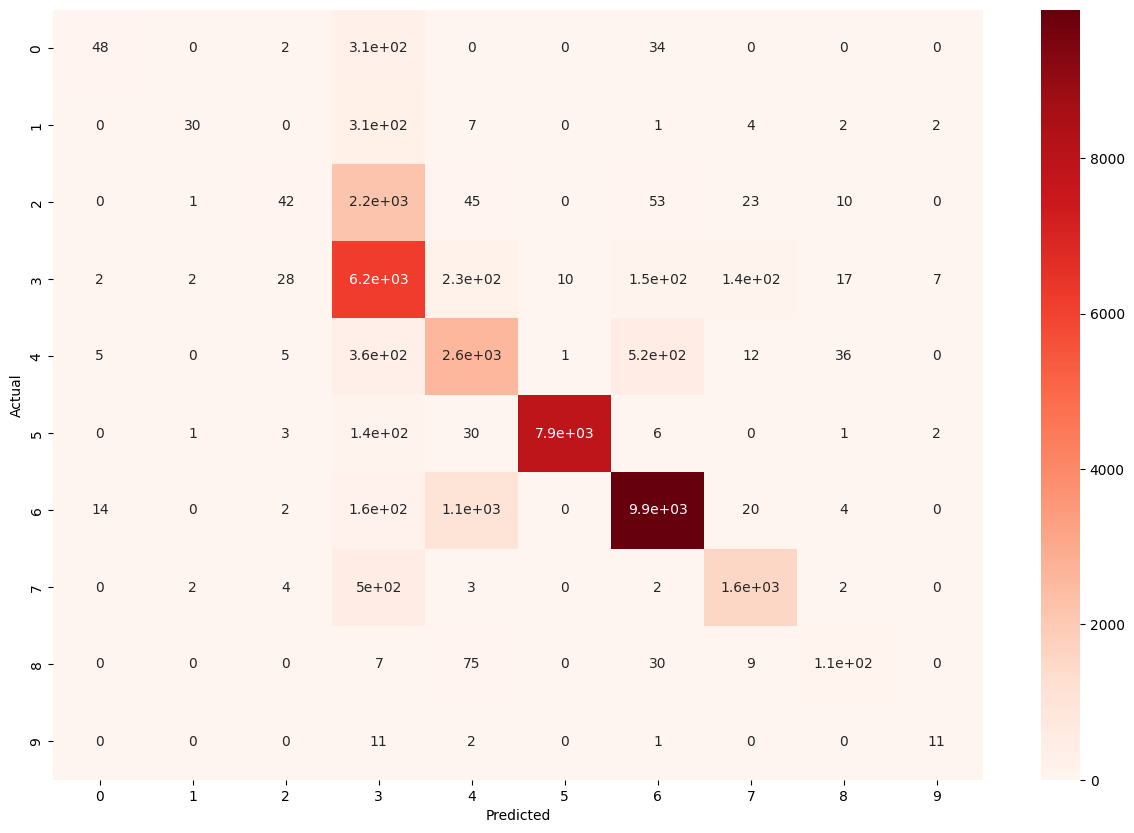


Classification Report:
{'0': {'precision': 0.6956521739130435, 'recall': 0.12213740458015267, 'f1-score': 0.20779220779220778, 'support': 393.0}, '1': {'precision': 0.8333333333333334, 'recall': 0.08333333333333333, 'f1-score': 0.15151515151515152, 'support': 360.0}, '2': {'precision': 0.4883720930232558, 'recall': 0.017721518987341773, 'f1-score': 0.034201954397394145, 'support': 2370.0}, '3': {'precision': 0.6076658476658476, 'recall': 0.9130242173656231, 'f1-score': 0.7296866702071163, 'support': 6772.0}, '4': {'precision': 0.6446949277137957, 'recall': 0.7369747899159664, 'f1-score': 0.6877532348712586, 'support': 3570.0}, '5': {'precision': 0.9986093552465234, 'recall': 0.9777200148533234, 'f1-score': 0.9880542873225342, 'support': 8079.0}, '6': {'precision': 0.9249790053186526, 'recall': 0.8875458859342824, 'f1-score': 0.9058759024033629, 'support': 11169.0}, '7': {'precision': 0.8842929010620458, 'recall': 0.7540514775977121, 'f1-score': 0.8139953691793157, 'support': 2098.0}, 

Accuracy Score,▁
f1-score_avg,▁
precision_avg,▁
recall_avg,▁
Accuracy Score,0.81129
f1-score_avg,0.78585
precision_avg,0.81428
recall_avg,0.81129


Train operation time: =  0.09517979621887207 seconds

Model: KNeighborsClassifier
Confusion Matrix:
[[  27    2   98  221   20    0   22    3    0    0]
 [   3    2  119  210   14    0   11    1    0    0]
 [   5   12  807 1330   72    1  114   25    4    0]
 [  51   32 1153 3845  759    1  794  131    6    0]
 [  21    7  180 1423 1214    3  623   69   28    2]
 [   1    0   35   98   33 7884   23    5    0    0]
 [  26    9   71 1382  726    3 8883   59    9    1]
 [   6    5  191  756  168    2  213  752    4    1]
 [   4    1   18   56   76    2   35   10   31    0]
 [   0    0    1   16    3    0    5    0    0    0]]


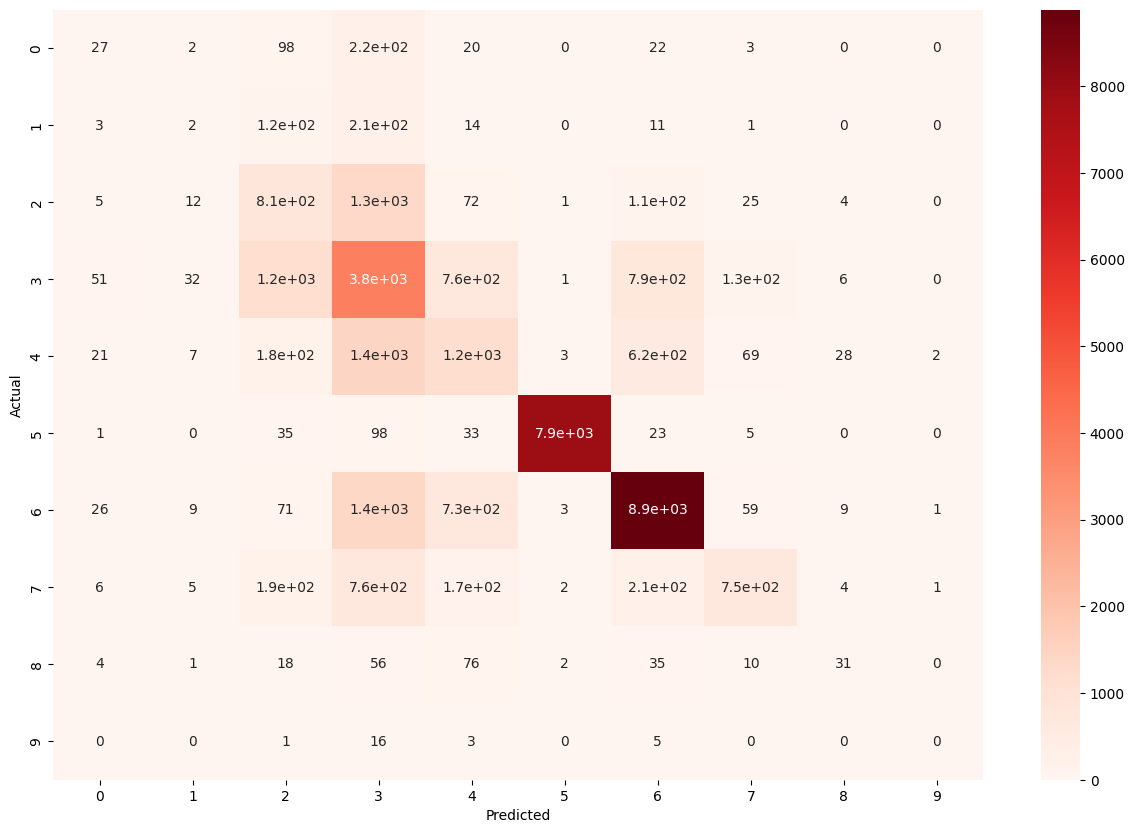


Classification Report:
{'0': {'precision': 0.1875, 'recall': 0.06870229007633588, 'f1-score': 0.1005586592178771, 'support': 393.0}, '1': {'precision': 0.02857142857142857, 'recall': 0.005555555555555556, 'f1-score': 0.00930232558139535, 'support': 360.0}, '2': {'precision': 0.30190796857463525, 'recall': 0.34050632911392403, 'f1-score': 0.32004759071980965, 'support': 2370.0}, '3': {'precision': 0.41180250615829495, 'recall': 0.5677790903721205, 'f1-score': 0.47737289713824566, 'support': 6772.0}, '4': {'precision': 0.393517017828201, 'recall': 0.3400560224089636, 'f1-score': 0.3648384673178062, 'support': 3570.0}, '5': {'precision': 0.9984802431610942, 'recall': 0.9758633494244338, 'f1-score': 0.9870422535211267, 'support': 8079.0}, '6': {'precision': 0.8284062295999254, 'recall': 0.7953263497179693, 'f1-score': 0.8115293257811073, 'support': 11169.0}, '7': {'precision': 0.7127962085308057, 'recall': 0.35843660629170637, 'f1-score': 0.47700602600697745, 'support': 2098.0}, '8': {'pr

Accuracy Score,▁
f1-score_avg,▁
precision_avg,▁
recall_avg,▁
Accuracy Score,0.66854
f1-score_avg,0.66787
precision_avg,0.68139
recall_avg,0.66854


Train operation time: =  1222.0920236110687 seconds

Model: SVC
Confusion Matrix:
[[  26    0    0  336    1    0   30    0    0    0]
 [   0    0    0  316   28    0    5   11    0    0]
 [   0    0   18 2197   96   13   18   28    0    0]
 [   1    0    4 6218  429   18   68   34    0    0]
 [   1    0    0  429 2796    0   80  264    0    0]
 [   0    0    3  145   42 7884    0    5    0    0]
 [  10    0    0  237 1813    8 8969  132    0    0]
 [   0    0    1  675  334    3    9 1076    0    0]
 [   0    0    0    0  144    0    0   89    0    0]
 [   0    0    1   21    2    0    0    1    0    0]]


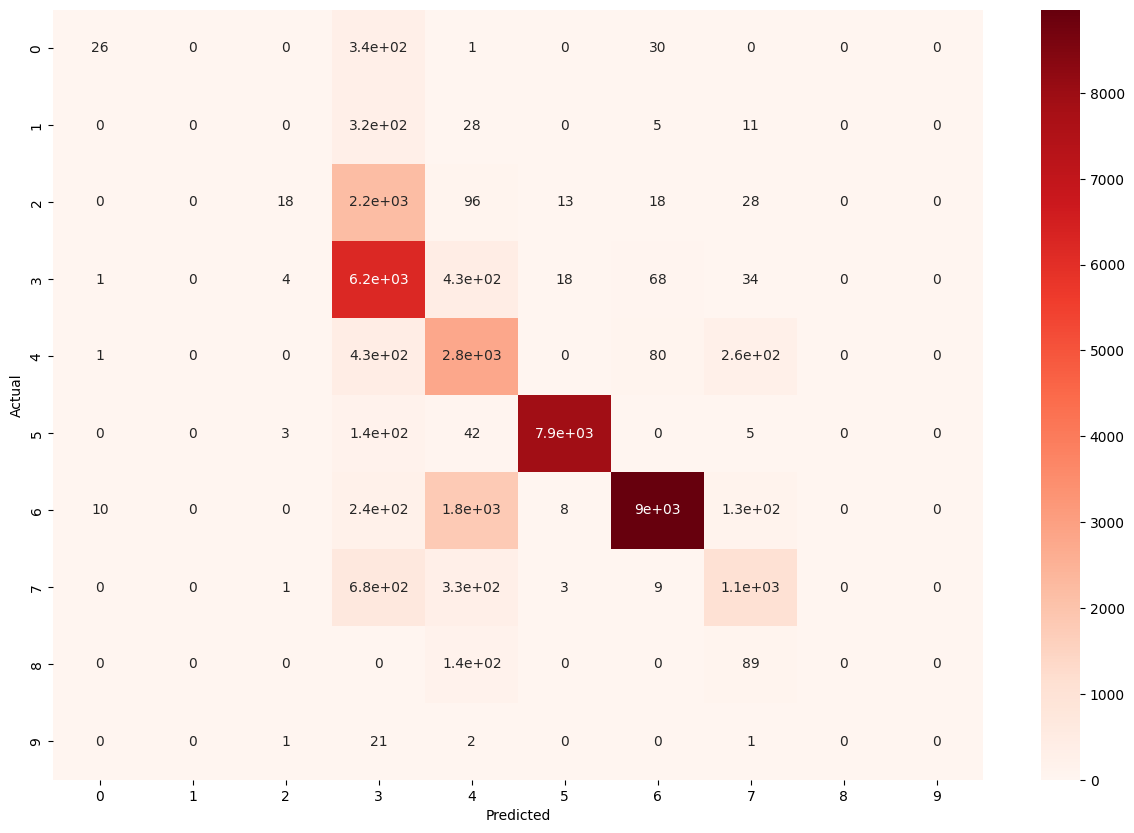

/home/brina/miniconda3/envs/gpu/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/brina/miniconda3/envs/gpu/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/brina/miniconda3/envs/gpu/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Classification Report:
{'0': {'precision': 0.6842105263157895, 'recall': 0.06615776081424936, 'f1-score': 0.12064965197215777, 'support': 393.0}, '1': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 360.0}, '2': {'precision': 0.6666666666666666, 'recall': 0.007594936708860759, 'f1-score': 0.01501877346683354, 'support': 2370.0}, '3': {'precision': 0.5880461509362588, 'recall': 0.9181925575900768, 'f1-score': 0.7169376225066298, 'support': 6772.0}, '4': {'precision': 0.49182058047493404, 'recall': 0.7831932773109244, 'f1-score': 0.6042139384116694, 'support': 3570.0}, '5': {'precision': 0.9947009841029523, 'recall': 0.9758633494244338, 'f1-score': 0.9851921274601686, 'support': 8079.0}, '6': {'precision': 0.977121690815993, 'recall': 0.80302623332438, 'f1-score': 0.8815608413603302, 'support': 11169.0}, '7': {'precision': 0.6560975609756098, 'recall': 0.5128693994280267, 'f1-score': 0.5757089352594971, 'support': 2098.0}, '8': {'precision': 0.0, 'recall': 0.0, 'f1-score':

Accuracy Score,▁
f1-score_avg,▁
precision_avg,▁
recall_avg,▁
Accuracy Score,0.76954
f1-score_avg,0.74449
precision_avg,0.79595
recall_avg,0.76954


In [43]:
# Loop through models and evaluate each one
project_name = "baseline-" + project_name
for model_name, model in models.items():
    wandb.init(project=project_name, name=model_name)
    
    # For SVM and Logistic Regression, use scaled data
    if model_name in ["Logistic Regression", "Support Vector Machine (SVM)"]:
        evaluate_model(model, X_train_scaled_df, y_train_df, X_test_scaled_df, y_test_df)
    else:
        evaluate_model(model, X_train_df, y_train_df, X_test_df, y_test_df)
        
    wandb.finish()

In [42]:
wandb.finish()